In [1]:
#DATA CLEANING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Read csv file also set its data type
df = pd.read_csv(
    'eco.csv',
    encoding='latin1',
    dtype={
        'CustomerID': str,
        'StockCode': str,
        'InvoiceNo': str,
        'Quantity': int,
        'UnitPrice': float
    }
)

#Change InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#remove duplicates
df=df.drop_duplicates()

# Drop rows where CustomerID is NaN or blank (only spaces)
df = df[df['CustomerID'].notna() & (df['CustomerID'].str.strip() != '')]

#Handle negative or zero quantities/prices if needed
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

#To add Revenue column by multiplying unit price and quantity
df['Revenue']=df['UnitPrice']*df['Quantity']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [2]:
# Max date
max_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Groupby Customer ID and use aggregate
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': 'max',      # last purchase date (Take recent(max))
    'InvoiceNo': 'nunique',    # frequency (count of unique invoices)
    'Revenue': 'sum'           # monetary (sum Of Revenue)
}).reset_index()

rfm


,CustomerID,InvoiceDate,InvoiceNo,Revenue
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,7,4310.00
2,12348,2011-09-25 13:13:00,4,1797.24
3,12349,2011-11-21 09:51:00,1,1757.55
4,12350,2011-02-02 16:01:00,1,334.40
...,...,...,...,...
4333,18280,2011-03-07 09:52:00,1,180.60
4334,18281,2011-06-12 10:53:00,1,80.82
4335,18282,2011-12-02 11:43:00,2,178.05
4336,18283,2011-12-06 12:02:00,16,2045.53


In [3]:
# Rename columns
rfm = rfm.rename(columns={
    'InvoiceDate': 'LastPurchaseDate',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
})

# Remove time part from LastPurchaseDate
rfm['LastPurchaseDate'] = rfm['LastPurchaseDate'].dt.normalize()

# Calculate Recency
rfm['Recency'] = (max_date - rfm['LastPurchaseDate']).dt.days

#arrange columns
rfm = rfm[['CustomerID', 'LastPurchaseDate', 'Recency', 'Frequency', 'Monetary']]
rfm

# Calculate R score (lower Recency is better, so direct qcut)
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first', ascending=False), q=5, labels=False, duplicates='drop') + 1

# Calculate F score (higher Frequency better, rank descending before qcut so higher values get higher scores)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=False, duplicates='drop') + 1

# Calculate M score (higher Monetary better, rank descending before qcut)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=False, duplicates='drop') + 1
rfm




,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,2011-01-18,326,1,77183.60,1,1,5
1,12347,2011-12-07,3,7,4310.00,5,5,5
2,12348,2011-09-25,76,4,1797.24,2,4,4
3,12349,2011-11-21,19,1,1757.55,4,1,4
4,12350,2011-02-02,311,1,334.40,1,1,2
...,...,...,...,...,...,...,...,...
4333,18280,2011-03-07,278,1,180.60,1,2,1
4334,18281,2011-06-12,181,1,80.82,1,2,1
4335,18282,2011-12-02,8,2,178.05,5,3,1
4336,18283,2011-12-06,4,16,2045.53,5,5,4


In [4]:
#Segment RFM
rfm 
def segment_customer(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return "CHAMPION"
    elif r >= 3 and f >= 4 and m >= 3:
        return "LOYAL CUSTOMER"
    elif r >= 4 and f >= 2 and m >= 2:
        return "POTENTIAL LOYALIST"
    elif r >= 4 and f <= 2:
        return "NEW CUSTOMERS"
    elif r >= 3 and f <= 2 and m >= 3:
        return "PROMISING"
    elif r >= 2 and f >= 2 and m >= 2:
        return "NEED ATTENTION"
    elif r <= 2 and f >= 3 and m >= 3:
        return "AT RISK"
    elif r <= 2 and f >= 4 and m >= 4:
        return "CAN'T LOSE THEM"
    elif r <= 2 and f <= 2 and m <= 2:
        return "HIBERNATING"
    else:
        return "ABOUT TO SLEEP"

rfm['Segment'] = rfm.apply(lambda x: segment_customer(x['R_Score'], x['F_Score'], x['M_Score']), axis=1)

rfm

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment
0,12346,2011-01-18,326,1,77183.60,1,1,5,ABOUT TO SLEEP
1,12347,2011-12-07,3,7,4310.00,5,5,5,CHAMPION
2,12348,2011-09-25,76,4,1797.24,2,4,4,NEED ATTENTION
3,12349,2011-11-21,19,1,1757.55,4,1,4,NEW CUSTOMERS
4,12350,2011-02-02,311,1,334.40,1,1,2,HIBERNATING
...,...,...,...,...,...,...,...,...,...
4333,18280,2011-03-07,278,1,180.60,1,2,1,HIBERNATING
4334,18281,2011-06-12,181,1,80.82,1,2,1,HIBERNATING
4335,18282,2011-12-02,8,2,178.05,5,3,1,ABOUT TO SLEEP
4336,18283,2011-12-06,4,16,2045.53,5,5,4,CHAMPION


In [5]:
rfm
# Count customers in each segment

segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
segment_counts

,Segment,Count
0,CHAMPION,942
1,NEED ATTENTION,801
2,HIBERNATING,766
3,ABOUT TO SLEEP,549
4,LOYAL CUSTOMER,461
5,POTENTIAL LOYALIST,422
6,NEW CUSTOMERS,187
7,AT RISK,111
8,PROMISING,99


In [6]:
# Calculate percentages
Total_customers=rfm['CustomerID'].nunique()
segment_counts['Percentage'] = (segment_counts['Count'] / Total_customers * 100).round(2)
segment_counts

,Segment,Count,Percentage
0,CHAMPION,942,21.72
1,NEED ATTENTION,801,18.46
2,HIBERNATING,766,17.66
3,ABOUT TO SLEEP,549,12.66
4,LOYAL CUSTOMER,461,10.63
5,POTENTIAL LOYALIST,422,9.73
6,NEW CUSTOMERS,187,4.31
7,AT RISK,111,2.56
8,PROMISING,99,2.28


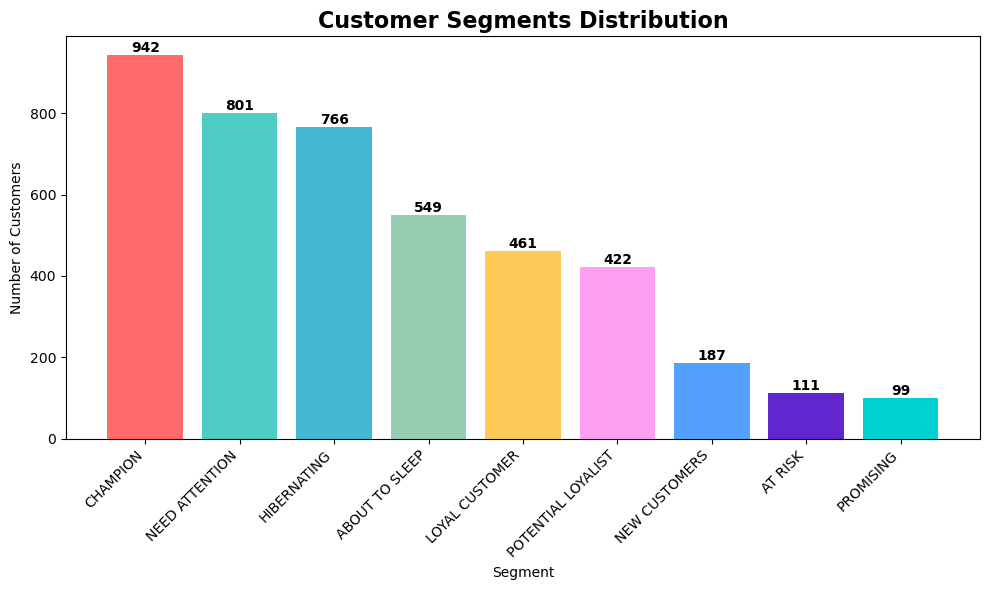

In [7]:
# Plot

# Bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(
    segment_counts['Segment'], 
    segment_counts['Count'], 
    color=[
        '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', 
        '#FECA57','#FF9FF3', '#54A0FF', '#5F27CD', 
        '#00D2D3', '#FF3838'
    ][:len(segment_counts)]
)

# Add labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,    # X position (center)
        bar.get_height(),                   # Y position (top of bar)
        str(int(bar.get_height())),         # Label
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.title("Customer Segments Distribution", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()





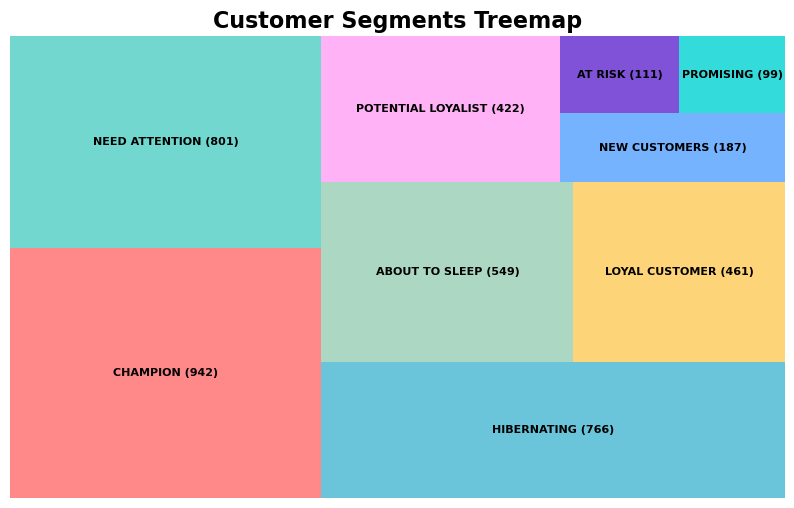

In [8]:
!pip install squarify

import matplotlib.pyplot as plt
import squarify  # pip install squarify

# Values and labels
sizes = segment_counts['Count']
labels = segment_counts['Segment'] + " (" + segment_counts['Count'].astype(str) + ")"

# Colors (slice to match length)
colors = [
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', 
    '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD', 
    '#00D2D3', '#FF3838'
][:len(segment_counts)]

# Plot treemap
plt.figure(figsize=(10,6))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.8,
    text_kwargs={'fontsize':8, 'weight':'bold'}
)

plt.title("Customer Segments Treemap", fontsize=16, fontweight='bold')
plt.axis('off')  # Hide axes
plt.show()
